In [1]:
import pandas as pd
import numpy as np

In [2]:
#Read the datafile into a DataFrame

df = pd.read_csv('c:/temp/bigcycledata.csv',dtype={'Watts':np.int,'Cadence':np.int,'HeartRate':np.int},parse_dates=True)
#df = pd.read_csv('c:/temp/bigcycledata.csv',parse_dates=True)

In [3]:
#Change the string datetime to a proper datetime format

df['datetime']=pd.to_datetime(df.Time)

# Set the elapsed duration between between each subsequent row 
# this would normally be 1 second, but sometimes it isn't
df['duration']=(df.datetime-df.datetime.shift(periods=1))

# Update the first value to 1 second, as our dataframe is not allowed to contain non numeric values
df.loc[df['duration'].isnull(),'duration']=np.timedelta64(1,'s')

In [4]:
#Create a list of all the wattages measured on the ride with this statement
#watts = df.Watts.value_counts().sort_index()

#Alternatively you can also just create a series with the values 0....n where n = df.Watts.max()
#and optionally reduce the dataset to 5 or 10 watt intervals

#for the purposes of this exercise lets use a reduced set of points
watts = pd.Series(index=[i for i in range (50,df.Watts.max()+1,10)])


In [5]:
#Now collect all the unbroken runs at or over a given wattage
#e.g. if i ride for 10 seconds and my watts are 100,105,110,105,110,105,105,120,125,125 
# there will be 
#   1 run of 10 seconds at 100 watts or over
#   1 run of 9 seconds at 105 watts or over
#   3 runs of 1,1 and 3 seconds at 110 watts or over
#   1 run of 3 seconds at 120 watts or over
#   1 run of 2 seconds at 125 watts or over

bigseries = pd.DataFrame()

# Run through each entry in the "watts" series and collect all the runs
for index,value in watts.items():
    df['minwatts'] = index
    df['rowqualifies'] = (df.Watts >= df.minwatts) * 1
    
    #we will use df.previousrowqualifies to figure out whether a new run has started
    df['previousrowqualifies'] = df.rowqualifies.shift(periods = 1)
    df.loc[df['previousrowqualifies'].isnull(),'previousrowqualifies'] = 0
    
    #the below is a slightly subversive method to determine individual runs
    df['runstart'] = ((df.rowqualifies == 1) & (df.previousrowqualifies == 0)) * 1
    df['runid'] = df.runstart.cumsum()*df.rowqualifies
    
    #calculate the run duration for each run and store in a new dataframe
    runs = pd.DataFrame(df[df.runid!=0].groupby(['runid','minwatts']).duration.sum())
    #reset the index so that the index become ordinary columns
    runs.reset_index(inplace=True)
    #add runs for this wattage to the big container
    bigseries = bigseries.append(runs)

#reset the index so that the index become ordinary columns    
bigseries.reset_index(inplace=True)


In [6]:
#Now that we have a record of every "run" at or over a certain wattage, we can collate them all together
intervals = bigseries.groupby(['minwatts','duration']).count()
intervals.reset_index(inplace=True)

#rename some of the columns just to make the code a bit more readable
intervals.rename(columns={'runid':'numruns','duration':'intervalduration'},inplace=True)
intervals['totalduration']=intervals.intervalduration*intervals.numruns

#add columns that turns the total duration from datetime datatypes to ordinary integers/floats
intervals['totalseconds']=intervals.totalduration.dt.total_seconds()
intervals['totalminutes']=intervals.totalseconds/60

In [7]:
#now it becomes quite easy to turn the run data into a powercurve
powercurve = pd.DataFrame(intervals.groupby(['minwatts']).totalminutes.sum())
powercurve.reset_index(inplace=True)

#and to determine the maximum interval length for a given wattage
maxintervals = pd.DataFrame(intervals.groupby(['minwatts']).totalseconds.max())
maxintervals.reset_index(inplace=True)

In [8]:
import matplotlib.pyplot as py

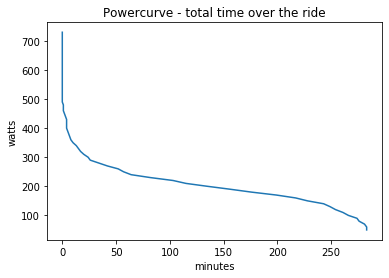

In [9]:
py.xlabel('minutes')
py.ylabel('watts')
py.title('Powercurve - total time over the ride')

py.plot(powercurve.totalminutes,powercurve.minwatts)

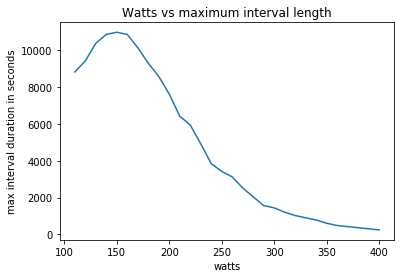

In [11]:
selectedintervals = maxintervals[(maxintervals.minwatts > 100) & (maxintervals.minwatts <= 400)]
py.xlabel('watts')
py.ylabel('max interval duration in seconds')
py.title('Watts vs maximum interval length')
py.plot(selectedintervals.minwatts,selectedintervals.totalseconds)